In [1]:
using CSV
using DataFrames
using DataFramesMeta
using StatsPlots
using DifferentialEquations
using Dates

This is more a data science post than machine learning. It was born after reading a [report](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf) from Imperial College London and finding a forecasting model by [NeherLab](https://neherlab.org/covid19/). The numbers produced by those models can only be described as terrifying. 

How do those models work? How are they calibrated?  

__BUT__

Whatever concerns one can have about their precision, those models are all absolutely clear that social-distancing, quarantining have a massive impact on death rates. Being careful saves lives. If anybody feels like ignoring those precautions out of excess testosterone, they are at risk of killing others. 

This post started from one of the pages of the NeherLab site describing their methodology. The work that team is achieving deserves more credit than I can give them. 

The NeherLab website, including the model, is entirely written in Javascript. This is difficul to understand and audit.

# Basic assumptions

### Overview

The model works as follows:

 - susceptible individuals are exposed/infected through contact with infectious individuals. Each infectious individual causes on average $R_0$ secondary infections while they are infectious.
 
Transmissibility of the virus could have seasonal variation which is parameterized with the parameter "seasonal forcing" (amplitude) and "peak month" (month of most efficient transmission).

- exposed individuals progress to a symptomatic/infectious state after an average latency

- infectious individuals recover or progress to severe disease. The ratio of recovery to severe progression depends on age

- severely sick individuals either recover or deteriorate and turn critical. Again, this depends on the age

- critically ill individuals either return to regular hospital or die. Again, this depends on the age

The individual parameters of the model can be changed to allow exploration of different scenarios.

<figure className="figure w-100 text-center">
  <img src={model} className="w-75 figure-img" alt="illustration of the model" />
  <figcaption className="figure-caption text-center">
    Figure 1. A schematic illustration of the underlying model. S corresponds to the 'susceptible' population,
    E is 'exposed', I is 'infectious', R 'recovered', H 'severe' (hospitalized), C 'critical' (ICU), and D are
    fatalities.
  </figcaption>
</figure>

### Age cohorts

COVID-19 is much more severe in the elderly and proportion of elderly in a community is therefore an important determinant of the overall burden on the health care system and the death toll. We collected age distributions for many countries from data provided by the UN and make those available as input parameters. Furthermore, we use data provided by the epidemiology group by the [Chinese CDC](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51) to estimate the fraction of severe and fatal cases by age group.

### Severity

The basic model deals with 3 levels of severity: slow, moderate and fast transmissions.

In [2]:
# severityLevel = :slow
severityLevel = :moderate
# severityLevel = :fast

:moderate

## Seasonality

Many respiratory viruses such as influenza, common cold viruses (including other coronaviruses) have a pronounced seasonal variation in incidence which is in part driven by climate variation through the year. We model this seasonal variation using a sinusoidal function with an annual period. This is a simplistic way to capture seasonality. Furthermore, we don't know yet how seasonality will affect COVID-19 transmission.


In [3]:
# Northern or southern hemisphere
latitude = :north
# latitude = :tropical
# latitude = :south

:north

In [4]:
# The time unit is days (as floating point)
# Day 0 is taken at 1 March 2020
BASE_DATE = Date(2020, 3, 1)
BASE_DAYS = 0

function date2days(d) 
    return convert(Float64, datetime2rata(d) - datetime2rata(BASE_DATE))
end

function days2date(d) 
    return BASE_DATE + Day(d)
end    

days2date (generic function with 1 method)

In [5]:
# Default values for R_0
baseR₀ = Dict( (:north,    :slow)     => 2.2, 
               (:north,    :moderate) => 2.7, 
               (:north,    :fast)     => 3.2, 
               (:tropical, :slow)     => 2.0, 
               (:tropical, :moderate) => 2.5, 
               (:tropical, :fast)     => 3.0,
               (:south,    :slow)     => 2.2, 
               (:south,    :moderate) => 2.7, 
               (:south,    :fast)     => 3.2)


Dict{Tuple{Symbol,Symbol},Float64} with 9 entries:
  (:tropical, :slow)     => 2.0
  (:tropical, :moderate) => 2.5
  (:north, :slow)        => 2.2
  (:south, :slow)        => 2.2
  (:north, :moderate)    => 2.7
  (:south, :fast)        => 3.2
  (:north, :fast)        => 3.2
  (:tropical, :fast)     => 3.0
  (:south, :moderate)    => 2.7

In [6]:
# Peak date
peakDate = Dict( :north     => date2days(Date(2020, 1, 1)), 
                 :tropical  => date2days(Date(2020, 1, 1)),    # although no impact
                 :south     => date2days(Date(2020, 7, 1)))

Dict{Symbol,Float64} with 3 entries:
  :tropical => -60.0
  :south    => 122.0
  :north    => -60.0

In [7]:
# Seasonal forcing parameter \epsilon
ϵ = Dict( (:north,    :slow)     => 0.2, 
          (:north,    :moderate) => 0.2, 
          (:north,    :fast)     => 0.1, 
          (:tropical, :slow)     => 0.0, 
          (:tropical, :moderate) => 0.0, 
          (:tropical, :fast)     => 0.0,
          (:south,    :slow)     => 0.2, 
          (:south,    :moderate) => 0.2, 
          (:south,    :fast)     => 0.1)

Dict{Tuple{Symbol,Symbol},Float64} with 9 entries:
  (:tropical, :slow)     => 0.0
  (:tropical, :moderate) => 0.0
  (:north, :slow)        => 0.2
  (:south, :slow)        => 0.2
  (:north, :moderate)    => 0.2
  (:south, :fast)        => 0.1
  (:north, :fast)        => 0.1
  (:tropical, :fast)     => 0.0
  (:south, :moderate)    => 0.2

In [8]:
# Gives R_0 at a given date
function R₀(d; r_0 = missing, latitude = :north, severity = :moderate)
    if ismissing(r_0)
        r₀ = baseR₀[(latitude, severity)]
    else
        r₀ = r_0
    end
    eps = ϵ[(latitude, severity)]
    peak = peakDate[latitude]
    
    return r₀ * (1 + eps * cos(2.0 * π * (d - peak) / 365.25))
end

R₀ (generic function with 1 method)

## Transmission reduction

The tool allows one to explore temporal variation in the reduction of transmission by infection
control measures. This is implemented as a curve through time that can be dragged by the mouse to
modify the assumed transmission. The curve is read out and used to change the transmission relative
to the base line parameters for $R_0$ and seasonality. Several studies attempt to estimate the
effect of different aspects of social distancing and infection control on the rate of transmission.
A report by [Wang et al](https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1) estimates a
step-wise reduction of $R_0$ from above three to around 1 and then to around 0.3 due to successive
measures implemented in Wuhan. [This study](https://www.pnas.org/content/116/27/13174) investigates
the effect of school closures on influenza transmission.

This curve is presented as a list of tuples: (days from start date, ratio). The month starts from the start date. Between dates, the ration is interpolated linearly. After the last date, the ration remains constant.

In [9]:
startDate = date2days(Date(2020, 3, 1))
mitigationRatio = [(0, 1.00), (30, 0.80), (60, 0.20), (150, 0.50)]

function getCurrentRatio(d; start = BASE_DAYS, schedule = mitigationRatio)
    l = length(schedule)
    
    # If l = 1, ratio will be the only one
    if l == 1 
        return schedule[1][2]
    else
        for i in 2:l
            d1 = schedule[i-1][1]
            d2 = schedule[i  ][1]
            
            if d < d2 
                deltaR = schedule[i][2] - schedule[i-1][2]
                return schedule[i-1][2] + deltaR * (d - d1) / (d2 - d1)
            end
        end
    
        # Last possible choice
        return schedule[l][2]
    end
end

getCurrentRatio (generic function with 1 method)

## Details of the model

Age strongly influences an individual's response to the virus. The general population is sub-divided in to age classes, indexed by $a$, to allow for variable transition rates dependent upon age.

In [10]:
# The population will be modeled as a single vector. 
# The vector will be a stack of several vectors, each of them represents a compartment.
# Each compartment vector has a size $nAgeGroup$ representing each age group.
# The compartments are: S, E, I, H, C, R, D, K, L

# We also track the hospital bed usage BED and ICU

# Compartments to population
#function Comp2Pop(S, E, I, H, C, R, D, K, L, BED, ICU)
#    return cat(S, E, I, H, C, R, D, K, L, BED, ICU)
#end

# Population to compartments
function Pop2Comp(P)
    
    # To make copy/paste less prone to error 
    g = 0
    
    S = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    E = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    I = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    J = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    H = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    C = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    R = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    D = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    K = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    L = P[ g*nAgeGroup + 1: (g+1)*nAgeGroup]; g += 1
    
    BED = P[ g*nAgeGroup + 1: g*nAgeGroup + 1]
    ICU = P[ g*nAgeGroup + 2: g*nAgeGroup + 2]
    
    return S, E, I, J, H, C, R, D, K, L, BED, ICU
end

Pop2Comp (generic function with 1 method)

### Population compartments

Qualitatively, the epidemy model dynamics tracks several sub-groups (compartments):

<img src="States.svg">

* Susceptible individuals ($S$) are healthy and susceptible to being exposed to the virus by contact with an infected individual.

* Exposed individuals ($E$) are infected but asymptomatic. They progress towards a symptomatic state on average time $t_l$. Reports are that asymptomatic individuals are contagious. We will assume that they are proportionally less contagious than symptomatic individuals as a percentage $\gamma_E$ of $R_0$. For the purposes of modelling we will assume (without supporting evidence, but will be the object of parameter estimation):

In [11]:
γₑ = 0.50

0.5

* Infected individuals ($I$) infect an average of $R_0$ secondary infections. On a time-scale of $t_i$, infected individuals either recover or progress towards severe infection.

From here on, the compartments differ from the NeherLab model is that we split compartments depending on the severity of the symptoms (Severe or Critical) and the location of the individual (out of the hospital infrastructure, isolated in hospital, or isolated in intensive care units). The transitions reflect the following assumptions:

* Transition between locations is purely a function of bed availability: as soon as beds are available, they are filled by all age groups in their respective proportions. 

* Transition from severe to critical is assumed to be independent from the location of the patient. For severe patients, the relevance of the location is whether they are isolated or not, that is the possibility to infect susceptible individual. The same way an asymptomatic individual's attracts a ratio $\gamma_e$, the other compartments will. The transition from $J$ and $H$ to recovery or criticality has a time-scale of $t_h$. 

In [12]:
# R_0 multipliers depending on severity. Subscript matches the compartment's name.
# Infected / symptomatic individuals
γᵢ=1.0

# Severe symptoms
γⱼ=1.5

# Critical symptoms
γₖ = 2.0

2.0

* Once critical, the location of a patient influences their chances of recovery. Although we will assume that the time to recovery is identical in all cases, we will assume that the risks will double and triple if a patient is in simple isolation (receiving care but without ICU equipmment) or out of hospital.   

In [13]:
# Fatality mulitplier.

# In ICU
δᵤ = 1.0

# In hospital
δₗ = 2.0

# Out of hospital
δₖ = 3.0

3.0

* The time-scale to recovery ($R$) or death ($D$) is $t_u$.

* Recovering and recovered individuals [$R$] can not be infected again. We will assume that recovering individual are not contagious (no medical experience for this assumption for recovering individual).

### Model parameters

 * Many estimates of $R_0$ are in the [range of 2-3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7001239/) with some estimates pointing to considerably [higher values](https://www.medrxiv.org/content/10.1101/2020.02.10.20021675v1).
 * The serial interval, that is the time between subsequent infections in a transmission chain, was [estimated to be 7-8 days](https://www.nejm.org/doi/full/10.1056/NEJMoa2001316).
 * The China CDC compiled [extensive data on severity and fatality of more than 40 thousand confirmed cases](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51).
 In addition, we assume that a substantial fraction of infections, especially in the young, go unreported. This is encoded in the columns "Confirmed [% of total]".
 * Seasonal variation in transmission is common for many respiratory viruses but the strength of seasonal forcing for COVID19 are uncertain. For more information, see a [study by us](https://smw.ch/article/doi/smw.2020.20224) and by [Kissler et al](https://www.medrxiv.org/content/10.1101/2020.03.04.20031112v1).
The parameters of this model fall into three categories: transition time scales, age-specfic parameters and a time-dependent infection rate.

#### Transition time scales

The time scales of transition from a compartment to the next: $t_l$, $t_i$, $t_h$, $t_c$. 

* $t_l$: latency time from infection to infectiousness 
* $t_i$: the time an individual is infectious after which he/she either recovers or falls severely ill
* $t_h$: the time a sick person recovers or deteriorates into a critical state
* $t_u$: the time a person remains critical before dying or stabilizing (Neherlab uses $t_c$ instead of $t_u$)

In [14]:
# Time to infectiousness (written t\_l)
tₗ = Dict(  :slow     => 5.0, 
            :moderate => 5.0, 
            :fast     => 4.0)

# Time to infectiousness (written t\_i)
tᵢ = Dict(  :slow     => 3.0, 
            :moderate => 3.0, 
            :fast     => 3.0)

# Time in hospital bed (not ICU)
tₕ = 4.0

# Time in ICU 
tᵤ = 14.0

14.0

#### Age-specfic parameters

The age-specific parameters $z_a$, $m_a$, $c_a$ and $f_a$ that determine relative rates of different outcomes. 

* $z_a$: a set of numbers reflecting to which extent an age group is susceptible to initial contagion. Note that NeherLab denotes this vector by $I_a$ which is confusing with the compartmment evolution $I_a(t)$ notation. (This sort of defeats the purpose of $R_0$.)
* $m_a$: fraction of infectious becoming severe (__Hospitalisation Rate__) or recovers immediately (__Recovery Rate__)
* $c_a$: fraction of severe cases that turn critical (__Critical Rate__) or can leave hospital (__Discharge Rate__)
* $f_a$: fraction of critical cases that are fatal (__Death Rate__) or recover (__Stabilisation Rate__)

In [15]:
AgeGroup = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
zₐ =       [0.05,   0.05,   0.10,    0.15,    0.20,    0.25,    0.30,    0.40,    0.50]
#zₐ =       [1.00,   1.00,   1.00,    1.00,    1.00,    1.00,    1.00,    1.00,    1.00]   
mₐ =       [0.01,   0.03,   0.03,    0.03,    0.06,    0.10,    0.25,    0.35,    0.50]
cₐ =       [0.05,   0.10,   0.10,    0.15,    0.20,    0.25,    0.35,    0.45,    0.55]
fₐ =       [0.30,   0.30,   0.30,    0.30,    0.30,    0.40,    0.40,    0.50,    0.50]

nAgeGroup = length(AgeGroup)


9

#### Infrastruture

The number of beds available is assumed as a fixed resource in time. The number of hospital (resp. ICU) beds in use will be denoted $\mathscr{H}(t)$ (resp. $\mathscr{U}(t)$)  up to a maximum of $\mathscr{H}_{max}$ (resp. $\mathscr{U}_{max}$). 

Although the initial infections took place via dommestic and international travellers (apart from the initial infections in Wuhan obviously), we will assume no net flow of population in and out of a country of interest. 

### Infection

#### Susceptible:

The _base_ rate of contagion is denoted as $R_0$. The actual rate varies with time (to reflect seasons and impact of temperature on virus resilience) and the effectiveness of the mitigation measures such as social distancing. Separately, each age group will have a different sensitivity to infection.

The infection rate $\beta_a(t)$ is age- and time-dependent. It is given by:

$$\beta_a(t) = z_a M(t) R_0 \left( 1+\varepsilon \cos \left( 2\pi \frac{t-t_{max}}{t_i} \right) \right) $$

where:
    
* $z_a$ is the degree to which particular age groups are sensitive to initial infection. It reflects bioligical sensitivity and to which degree it is isolated from the rest of the population (denoted $I_a$ in NeherLab).
* $M(t)$ is a time-dependent ratio reflecting the effectiveness of mitigation measures.
* $\varepsilon$ is the amplitude of seasonal variation in transmissibility.
* $t_{max}$ is the time of the year of peak transmission.

Susceptible individuals are exposed to a number of contagious individuals: 

* asymptomatic infected:  $$\gamma_e \beta_a(t) E_a(t)$$
* symptomatic infected: $$\gamma_i \beta_a(t) I_a(t)$$
* severe not in hospital: $$\gamma_j \beta_a(t) J_a(t)$$
* critical not in hospital: $$\gamma_k \beta_a(t) K_a(t)$$

The sum of those will be a flow from susceptible ($S$) to ($E$) exposed individuals.

$$
\begin{aligned}
S2E_a(t) & = \gamma_e \beta_a(t) E_a(t) + \gamma_i \beta_a(t) I_a(t) + \gamma_j \beta_a(t) K_a(t) + \gamma_k \beta_a(t) L_a(t) \\ 
S2E_a(t) & = \beta_a(t) \left( \gamma_e  E_a(t) + \gamma_i I_a(t) + \gamma_j J_a(t) + \gamma_k K_a(t) \right) \\
E2S_a(t) & = -S2E_a(t) \\
\end{aligned}
$$


and therefore:

$$
\frac{dS_{a}(t)}{dt} = - S2E_a(t) = E2S_a(t)
$$

### After infection

Quantitatively, the model expresses how many individuals transfer from one situation/compartment to another. Flows from compartment X to Y are written as $X2Y$ (obviously $X2Y = - Y2X$).

Note that the compartments are split into age groups. 

<img src="Transitions.svg">

#### Epidemiology

Instead of expressing the sum of the flows at each node, it is easier to express the arrows, and summing them afterwards. For example, arrow from $J$ to $K$ will be:

$$JK_a(t) = \frac{c_a}{t_h} J_a(t)$$

with a positive flow following the direction of the arrow. 

In Julia, this will become:

```
        JK = cₐ .* J / tₕ
```
where `J` is a vector representing an age group, `.*` is the element-wise multiplication.

After defining the arrows $IJ$, $JK$ and $JH$, the change in $J$ will simply be:

```
        dJ = IJ - JK - JH
```


#### Bed transfers

Individuals are transferred into hospital beds then into ICU beds in the order indicated by the red numbers.

Critical patients already in hospital go into ICU as spots become available. The freed bed are first made available to critical patients out of hospital ($K$). Then, any free beds will receive patients in severe condition. 

#### Safeguards:

Note the need to ensure a few common sense rules:

* No compartment can have a negative number of people.

* The total population figure should remain unchanged. This is done by adjusting the number of susceptible individuals.

* Careful accounting of the use of fixed number of hospital beds.

* The number of infected people should always be above the number of reported cases. 


In [16]:
# Helper function to never change the number of individuals in a compartment in a way that would 
# make it below 0.1 (to avoid rounding errors around 0)
function ensurePositive(d,s)
    return max.(d .+ s, 0.1) .- s
end

    
    
# The dynamics of the epidemy is a function that mutates its argument with a precise signature
# Don't pay too much attetion to the print debugs/

function epiDynamics!(dP, P, params, t)
    
    S, E, I, J, H, C, R, D, K, L, BED, ICU = Pop2Comp(P)
    
    BED = BED[1]
    ICU = ICU[1]
    
    r₀, tₗ, tᵢ, tₕ, tᵤ, γₑ, γᵢ, γⱼ, γₖ, δₖ, δₗ, δᵤ, startDays = params 
    
    
    ####################################
    # Arrows reflecting epidemiology - Check signs (just in case)
    EI = ones(nAgeGroup) .* E / tₗ;  EI = max.(EI, 0.0); IE = -EI; 
    IJ = mₐ              .* I / tᵢ;  IJ = max.(IJ, 0.0); JI = -IJ
    JK = cₐ              .* J / tₕ;  JK = max.(JK, 0.0); KJ = -JK
    HL = cₐ              .* H / tₕ;  HL = max.(HL, 0.0); LH = -HL
    
    # Recovery arrows
    IR = (1 .- mₐ)       .* I / tᵢ;  IR = max.(IR, 0.0); RI = -IR
    JR = (1 .- cₐ)       .* J / tₕ;  JR = max.(JR, 0.0); RJ = -JR
    HR = (1 .- cₐ)       .* H / tₕ;  HR = max.(HR, 0.0); RH = -HR
    KR = (1 .- δₖ .* fₐ) .* K / tᵤ;  KR = max.(KR, 0.0); RK = -KR
    LR = (1 .- δₗ .* fₐ) .* L / tᵤ;  LR = max.(LR, 0.0); RL = -LR
    CR = (1 .- δᵤ .* fₐ) .* C / tᵤ;  CR = max.(CR, 0.0); RC = -CR
    
    # Deaths
    KD = δₖ .* fₐ        .* K / tᵤ;  KD = max.(KD, 0.0); DK = -KD
    LD = δₗ .* fₐ        .* L / tᵤ;  LD = max.(LD, 0.0); DL = -LD
    CD = δᵤ .* fₐ        .* C / tᵤ;  CD = max.(CD, 0.0); DC = -CD
    
    
    ####################################
    # Bed transfers
    
    ####### Step 1:
    # Decrease in bed usage is (recall that CD and CR are vectors over the age groups) 
    dICU = - (sum(CD) + sum(CR));                 dICU = ensurePositive(dICU, ICU)
    
    # ICU beds available
    ICU_free = ICU_max - (ICU + dICU)
    
    # Move as many patients as possible from $L$ to $C$ in proportion of each group
    ICU_transfer = min(sum(L), ICU_free)
    LC = ICU_transfer / sum(L) .* L;    CL = -LC
    
    # Overall change in ICU bed becomes
    dICU = dICU + ICU_transfer;                   dICU = ensurePositive(dICU, ICU)
    
    # And some normal beds are freed
    dBED = -ICU_transfer;                         dBED = ensurePositive(dBED, BED)
    #print(" dBed step 1 "); println(floor.(sum(dBED)))

    ####### Step 2:
    # Beds available
    BED_free = BED_max - (BED + dBED)
    
    # Move as many patients as possible from $K$ to $L$ in proportion of each group
    BED_transfer = min(sum(K), BED_free)
    KL = BED_transfer / sum(K) .* K;   LK = -KL
    
    # Overall change in normal bed becomes
    dBED = dBED + BED_transfer;                   dBED = ensurePositive(dBED, BED)
    #print(" dBed step 2 "); println(floor.(sum(dBED)))
    

    ####### Step 3:
    # Beds available
    BED_free = BED_max - (BED + dBED)
    
    # Move as many patients as possible from $J$ to $H$ in proportion of each group
    BED_transfer = min(sum(J), BED_free)
    JH = BED_transfer / sum(J) .* J;   HJ = -JH 
    
    # Overall change in ICU bed becomes
    dBED = dBED + BED_transfer;                   dBED = ensurePositive(dBED, BED)
    #print(" dBed step 3 "); println(floor.(sum(dBED)))
    

    ####################################
    # Sum of all flows + Check never negative compartment
    
    # Susceptible    
    # Calculation of β
    β = getCurrentRatio(t; start = BASE_DAYS, schedule = mitigationRatio) .* zₐ .* 
        R₀(t; r_0 = r₀, latitude = Latitude, severity = SeverityLevel)
    
    #print("r₀"); println(r₀); println("R₀"); 
    #println(R₀(t; r_0 = r₀, latitude = Latitude, severity = SeverityLevel)); print()
    
    dS = -β .* (γₑ.*E + γᵢ.*I + γⱼ.*J + γₖ.*K);   dS = min.(-0.01, dS); dS = ensurePositive(dS, S)
    
    #print("dS"); println(floor.(dS)); println(); 
    
    # Exposed
    dE = -dS + IE;                                dE = ensurePositive(dE, E)
    
    # Infected. 
    dI = EI + JI + RI;                            dI = ensurePositive(dI, I)
    
    # Infected no hospital
    dJ = IJ + HJ + KJ + RJ;                       dJ = ensurePositive(dJ, J)
    
    #print("I "); println(floor.(IJ)); print("H "); println(floor.(HJ))
    #print("K "); println(floor.(KJ)); print("R "); println(floor.(RJ))
    
    # Infected in hospital
    dH = JH + LH + RH ;                           dH = ensurePositive(dH, H)
    
    # Critical no hospital
    dK = JK + LK + DK + RK;                       dK = ensurePositive(dK, K)
    
    # Critical in hospital
    dL = KL + HL + CL + DL + RL;                  dL = ensurePositive(dL, L)
    
    # Critical in ICU
    dC = LC + DC + RC;                            dC = ensurePositive(dC, C)
    
    # Recovery (can only increase)
    dR = IR + JR + HR + KR + LR + CR;             dR = max.(dR, 0.01)
    
    # Dead (can only increase)
    dD = KD + LD + CD;                            dD = max.(dD, 0.01)
    
    # Vector change of population and update in place
    result = vcat(dS, dE, dI, dJ, dH, dC, dR, dD, dK, dL, [dBED], [dICU])
    #print(" dS "); print(floor.(sum(dS))); print(" dE "); print(floor.(sum(dE))); 
    #print(" dI "); print(floor.(sum(dI))); print(" dJ "); println(floor.(sum(dJ))); 
    #print(" dH "); print(floor.(sum(dH))); print(" dC "); print(floor.(sum(dC))); 
    #print(" dR "); print(floor.(sum(dR))); print(" dD "); print(floor.(sum(dD))); 
    #print(" dK "); print(floor.(sum(dK))); print(" dL "); println(floor.(sum(dL))); println(); 
    for i = 1:length(result)
        dP[i] = result[i]
    end

end



epiDynamics! (generic function with 1 method)

# Load data

The data comes from Neherlab's data repository on [Github](https://github.com/neherlab/covid19_scenarios_data).

In [17]:
# Adjust as necessary. The data lives in a data/ folder below this.
cd("$(homedir())/Development/git/COVID19/COVID-19-Julia")

We will use Italy as an example

In [18]:
country = "Italy"

"Italy"

In [19]:
populationData = DataFrame(CSV.read("data/populationData.tsv"))
populationData = @where(populationData, occursin.(country, :name)) 
first(populationData, 6)

,name,populationServed,ageDistribution,hospitalBeds,ICUBeds,suspectedCaseMarch1st
,String,Int64,String,Int64,Int64,Int64
1,Italy,60462000,Italy,165384,7550,225600


This file contains a record of cases day by day.

In [20]:
cases = DataFrame(CSV.read("data/World.tsv", header = 4))
cases = @where(cases, occursin.(country, :location)) 
sort!(cases, :time)

# Add a time column in the same format as the other dataframes
cases = hcat(DataFrame(t = date2days.(cases[:, :time])), cases)

last(cases, 6)

,t,location,time,cases,deaths,hospitalized,ICU,recovered
,Float64,String,Date,Int64,Int64,Missing,Missing,Missing
1,16.0,Italy,2020-03-17,27980,2158,missing,missing,missing
2,17.0,Italy,2020-03-18,31506,2505,missing,missing,missing
3,18.0,Italy,2020-03-19,35713,2978,missing,missing,missing
4,19.0,Italy,2020-03-20,41035,3407,missing,missing,missing
5,20.0,Italy,2020-03-21,47021,4032,missing,missing,missing
6,21.0,Italy,2020-03-22,53578,4827,missing,missing,missing


Plotting the number of death shows an almost exponential increase in numbers (straight lin in logarithmic scale).

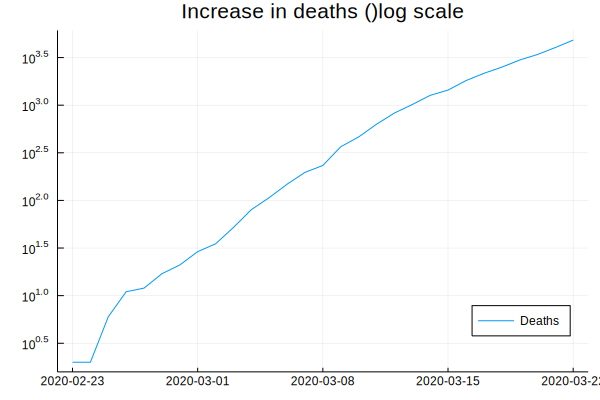

In [21]:
@df @where(cases, :deaths .> 0.0) plot(:time, :deaths, title = "Increase in deaths ()log scale", label = "Deaths", legend = :bottomright)
plot!(yaxis = (:log10))

This file contains ICU beds figures.

In [22]:
ICU_capacity = select(CSV.read("data/ICU_capacity.tsv"; delim = "\t"), :country, :CriticalCare)
ICU_capacity = @where(ICU_capacity, occursin.(country, :country))[!, :CriticalCare][1]
ICU_capacity = convert(Float64, ICU_capacity)

thread = 1 warning: only found 6 / 9 columns on data row: 32. Filling remaining columns with `missing`


7550.0

Country codes are necessary to load the another file.

In [23]:
country_codes = select(CSV.read("data/country_codes.csv"), :name, Symbol("alpha-3"))
country_codes = @where(country_codes, occursin.(country, :name))
countryShort = country_codes[:, Symbol("alpha-3")][1]

thread = 1 warning: only found 10 / 11 columns on data row: 121. Filling remaining columns with `missing`


"ITA"

This file contains hospital beds figures.

In [24]:
hospital_capacity = select(CSV.read("data/hospital_capacity.csv", types = Dict(:COUNTRY => String), limit = 1267), :COUNTRY, :YEAR, :VALUE)
hospital_capacity = @where(hospital_capacity, Not(ismissing.(:COUNTRY)))
hospital_capacity = last(@where(hospital_capacity, occursin.(countryShort, :COUNTRY)), 1)[!, :VALUE][1]
hospital_capacity = convert(Float64, hospital_capacity)

165384.0

This file contains a distribution of the population in age groups.

In [25]:
age_distribution = CSV.read("data/country_age_distribution.csv")
age_distribution = @where(age_distribution, occursin.(country, :_key))[!, 2:10]
# Convert to simple matrix
age_distribution = Matrix(age_distribution)
show(age_distribution)

[4994996 5733447 6103437 6998434 9022004 9567192 7484860 6028907 4528548]

# Initialise parameters

## Fixed constants

In [26]:
SeverityLevel = :moderate
Latitude = :north

StartDate = Date(2020, 3, 1)
StartDays = date2days(StartDate)

EndDate = Date(2020, 9, 1)
EndDays = date2days(EndDate)

tSpan = (StartDays, EndDays);

## Infrastructure

In [27]:
BED_max = hospital_capacity

165384.0

In [28]:
ICU_max = ICU_capacity

7550.0

## Parameter vector

In [29]:
# r₀, tₗ, tᵢ, tₕ, tᵤ, γᵢ, γⱼ, γₖ, δₖ, δₗ, δᵤ, startDate = params 

parameters = [  baseR₀[Latitude, SeverityLevel], 
                tₗ[SeverityLevel], tᵢ[SeverityLevel], tₕ, tᵤ, 
                γₑ, γᵢ, γⱼ, γₖ, 
                δₖ, δₗ, δᵤ, 
                StartDays];

## Population

In [30]:
Age_Pyramid = transpose(age_distribution)
Age_Pyramid_frac = Age_Pyramid / sum(Age_Pyramid);

We do not know the number of actual number of infections cases at the start of the model. We only know confirmed cases (almost certainly far below the number of actual infections).

We assume that actual infections are 3 time more numerous. 

In [31]:
DeathsAtStart = @where(cases, :time .== StartDate)[!, :deaths][1]
ConfirmedAtStart = @where(cases, :time .== StartDate)[!, :cases][1]
EstimatedAtStart = 3.0 * ConfirmedAtStart

3384.0

## Parameters vector

In [32]:
# Note that values are inintialised at 1 to avoid division by zero

S0 = Age_Pyramid
E0 = ones(nAgeGroup)
I0 = EstimatedAtStart * Age_Pyramid_frac
J0 = ones(nAgeGroup)
H0 = ones(nAgeGroup)
C0 = ones(nAgeGroup)
R0 = ones(nAgeGroup)
D0 = DeathsAtStart * Age_Pyramid_frac
K0 = ones(nAgeGroup)
L0 = ones(nAgeGroup)

# Everybody confirmed is in hospital
BED = [ConfirmedAtStart]
ICU = [1.0]

P0 = vcat(S0, E0, I0, J0, H0, C0, R0, D0, K0, L0, BED, ICU)
dP = 0 * P0;

# Differential equation solver

In [33]:
model = ODEProblem(epiDynamics!, P0, tSpan, parameters);

In [34]:
# Note: progress steps might be too quick to see!
sol = solve(model, Tsit5(); progress = true, progress_steps = 5);

ODE: 100%|█████████████████████████████████████████| Time: 0:00:03


In [35]:
# The solutions are returned as an Array of Arrays: 
#  - it is a vector of size the number of timesteps
#  - each element of the vector is a vector of all the variables
nSteps = length(sol.t)
nVars  = length(sol.u[1])

# Empty dataframe to contain all the numbers
# (When running a loop at top-level, the global keywrod is necessary to modify global variables.)
solDF = zeros((nSteps, nVars))
for i = 1:nSteps
    global solDF
    solDF[i, :] = sol.u[i]
end

solDF = hcat(DataFrame(t = sol.t), DataFrame(solDF))

# Let's clean the names
compartments =  ["S", "E", "I", "J", "H", "C", "R", "D", "K", "L"]
solnames = vcat([:t], [Symbol(c * repr(n)) for c in compartments for n in 0:(nAgeGroup-1)], [:Beds], [:ICU])
rename!(solDF, solnames);


In [36]:
# Create sums for each compartment
for c in compartments
    col =  [Symbol(c * repr(n)) for n in 0:(nAgeGroup-1)]
    s = DataFrame(C = sum.(eachrow(solDF[:, col])))
    rename!(s, [Symbol(c)])
        
    solDF = hcat(solDF, s)
end

# The D column gives the final number of dead.
last(solDF[:, Symbol.(compartments)], 10)

,S,E,I,J,H,C,R,D,K
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.33977e7,346.954,213.08,9.64134,0.900091,213.604,3.39105e7,3.15646e6,1.11408
2,2.33975e7,341.506,209.087,9.41623,0.900025,177.886,3.39107e7,3.15647e6,1.10562
3,2.33972e7,336.015,204.985,9.19059,0.900023,142.242,3.3911e7,3.15649e6,1.09714
4,2.3397e7,331.563,201.386,8.9885,0.900054,110.574,3.39113e7,3.1565e6,1.08952
5,2.33967e7,329.213,198.985,8.83745,0.900162,86.0814,3.39116e7,3.15651e6,1.08375
6,2.33964e7,329.205,197.998,8.74626,0.90034,68.6706,3.39119e7,3.15652e6,1.08017
7,2.33962e7,331.238,198.26,8.7075,0.900438,56.3625,3.39121e7,3.15653e6,1.0785
8,2.3396e7,335.081,199.606,8.71276,0.900393,47.3365,3.39123e7,3.15653e6,1.07845
9,2.33957e7,340.754,202.011,8.75898,0.9003,40.4384,3.39126e7,3.15654e6,1.07987


The last row shows the final sizes of the various compartments.

Next is the evolution of the over time.

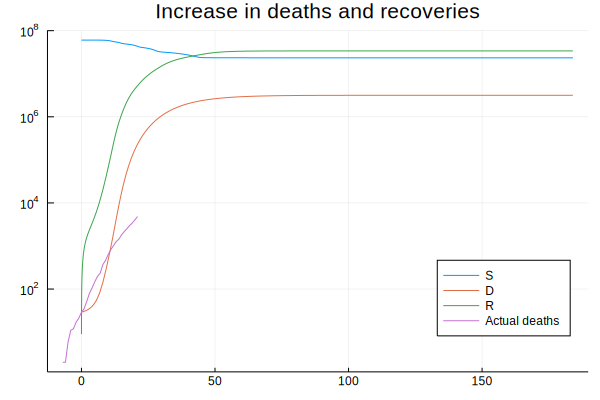

In [37]:
@df solDF plot(:t, :S, label = "S", legend = :topright, title = "Increase in deaths and recoveries")
#@df solDF plot!(:t, :E, label = "E")
#@df solDF plot!(:t, :I, label = "I")
#@df solDF plot!(:t, :J, label = "J")
#@df solDF plot!(:t, :H, label = "H")
#@df solDF plot!(:t, :K, label = "K")
#@df solDF plot!(:t, :L, label = "L")
#@df solDF plot!(:t, :C, label = "C")
@df solDF plot!(:t, :D, label = "D")
@df solDF plot!(:t, :R, label = "R")

@df @where(cases, :deaths .> 0.0) plot!(:t, :deaths, label = "Actual deaths", legend = :bottomright)

plot!(yaxis = (:log10))

It is clear the model forecasts a faster growth than reality. A parameter estimaation is necessary.

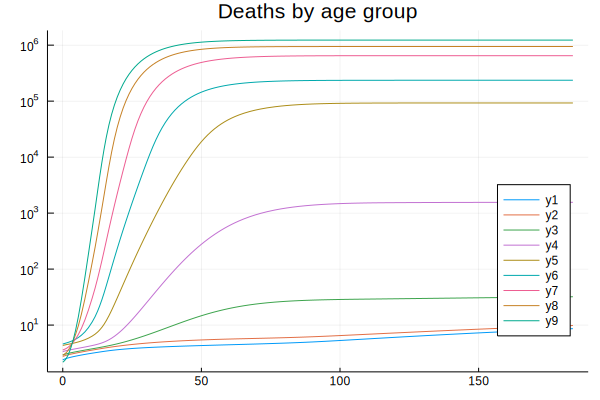

In [38]:
@df solDF plot(:t, [:D0 ,:D1, :D2, :D3, :D4, :D5, :D6, :D7, :D8], title = "Deaths by age group", yscale = :log10, legend = :bottomright)

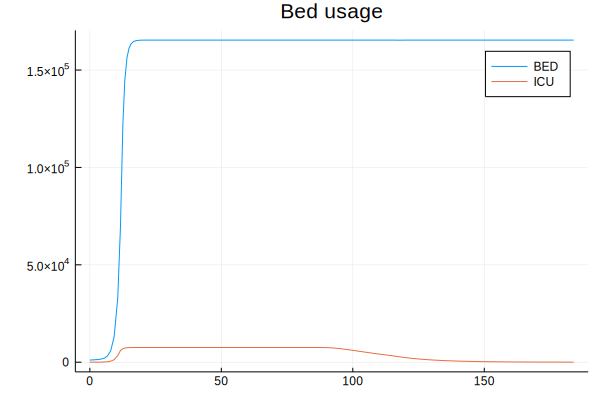

In [39]:
@df solDF plot( :t, :Beds, label = "BED", legend = :topright, title = "Bed usage")
@df solDF plot!(:t, :ICU, label = "ICU")


# Bilibliography

The Novel Coronavirus Pneumonia Emergency Response Epidemiology Team. The Epidemiological Characteristics of an Outbreak of 2019 Novel Coronavirus Diseases (COVID-19) — China, 2020[J]. China CDC Weekly, 2020, 2(8): 113-122. [LINK](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)